In this experiment, we use the Swin UNETR models pretrained on BraTS21 dataset available via the link https://github.com/Project-MONAI/research-contributions/tree/main/SwinUNETR/BRATS21#models.

First, we obtain the true segmentation and predicted segmentation following the instructions https://github.com/Project-MONAI/research-contributions/tree/main/SwinUNETR/BRATS21#evaluation. We save the segmentations with the three original channels corresponding to ED, ET, NCR and analyze each channel separately.

In [1]:
import torch
import gudhi
import plotly
import plotly.graph_objects as go

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def get_coords(a):
    start_coords = []
    end_coords = []
    for i in range(a.ndim):
        other_ax = tuple([j for j in range(a.ndim) if i != j])
        is_any = np.any(a == 1., axis=other_ax)
        assert is_any.sum() > 0
        start_index = np.where(is_any == True)[0][0]
        end_index = np.where(is_any == True)[0][-1]
        start_coords.append(start_index)
        end_coords.append(end_index)
    return start_coords, end_coords

In [4]:
def make_reduction(a, start_coords, end_coords):
    a_reduced = a[max(0, start_coords[0] - 1) : min(a.shape[0], end_coords[0] + 2),
                  max(0, start_coords[1] - 1) : min(a.shape[1], end_coords[1] + 2),
                  max(0, start_coords[2] - 1) : min(a.shape[2], end_coords[2] + 2)]
    return a_reduced

In [5]:
def get_reduced_object(a):
    start_coords, end_coords = get_coords(a)
    a_reduced = make_reduction(a, start_coords, end_coords)
    return a_reduced

In [6]:
def get_aligned_coords(start_coords_1, start_coords_2, end_coords_1, end_coords_2):
    start_coords = np.minimum(start_coords_1, start_coords_2)
    end_coords = np.maximum(end_coords_1, end_coords_2)
    return start_coords, end_coords

In [7]:
def get_aligned_objects(a, b):
    start_coords_a, end_coords_a = get_coords(a)
    start_coords_b, end_coords_b = get_coords(b)
    start_coords, end_coords = get_aligned_coords(start_coords_a, start_coords_b,
                                                  end_coords_a, end_coords_b)
    a_aligned = make_reduction(a, start_coords, end_coords)
    b_aligned = make_reduction(b, start_coords, end_coords)
    return a_aligned, b_aligned

In [8]:
class SFDLossGudhi:
    def __init__(self, dims = [1], card = 100, use_max = False, p = 1, min_barcode = 0.0):
        self.dims = dims
        self.card = card
        self.use_max = use_max
        self.p = p
        self.min_barcode = min_barcode

    def __call__(self, F1, G1):
        D_size = torch.Size([3] + list(F1.shape))
        D = torch.zeros(D_size, dtype = F1.dtype)

        if not self.use_max:
            D[0] = torch.min(F1, G1)
            D[1] = F1
            D[2] = torch.min(torch.min(F1, G1)).expand(F1.shape)
        else:
            D[0] = F1
            D[1] = torch.max(F1, G1)
            D[2] = torch.min(torch.min(F1)).expand(F1.shape)

        cubical_complex = gudhi.CubicalComplex(vertices = D.detach().numpy())
        cubical_complex.compute_persistence(homology_coeff_field = 2, min_persistence = 0.0)

        v = cubical_complex.vertices_of_persistence_pairs()

        D_fortran = D.permute(*torch.arange(D.ndim - 1, -1, -1))
        D_flat = D_fortran.reshape(D.numel())

        loss = 0.

        self.v = v
        self.D = D
        self.cubical_complex = cubical_complex

        for dim in self.dims:

            if v[0] and len(v[0]) >= dim + 1:

                r = []

                for elem in v[0][dim]:
                    i, j = elem
                    if D_flat[j] - D_flat[i] > self.min_barcode:
                        r.append((D_flat[i], D_flat[j]))

                r_sorted = sorted(r, key = lambda x : x[1].item() - x[0].item(), reverse = True)
                part_loss = sum(list(map(lambda x : (x[1] - x[0]) ** self.p, r_sorted[:self.card])))

                loss += part_loss

        return loss

In [9]:
def plot_barcodes(arr, color_list = ['deepskyblue', 'limegreen', 'darkkhaki', 'indianred'],
                  dark_color_list = None, title = '', hom = None):

    if dark_color_list is None:
        dark_color_list = color_list

    sh = len(arr)
    step = 0
    if (len(color_list) < sh):
        color_list *= sh

    for i in range(sh):

        if not (hom is None):
            if i not in hom:
                continue

        barc = arr[i].copy()
        arrayForSort = np.subtract(barc[:,1],barc[:,0])

        bsorted = np.sort(arrayForSort)
        nbarc = bsorted.shape[0]
        
        if nbarc:
            plt.plot(barc[0], np.ones(2)*step, color = color_list[i], label = 'H{}'.format(i))
            for b in barc:
                plt.plot(b, np.ones(2)*step, color = color_list[i])
                step += 1

    plt.xlabel('$\epsilon$ (time)')
    plt.ylabel('segment')
    plt.title(title)
    plt.legend(loc = 'lower right')
    plt.rcParams["figure.figsize"] = [6, 4]

In [10]:
def visualize(o, features=None):
    s1, s2, s3 = o.shape
    X, Y, Z = np.mgrid[0:s1:complex('{}j'.format(s1)),
                       0:s2:complex('{}j'.format(s2)),
                       0:s3:complex('{}j'.format(s3))]
    values = o

    fig = go.Figure(data=go.Volume(
        x=X.flatten(),
        y=Y.flatten(),
        z=Z.flatten(),
        value=values.flatten(),
        isomin=0.1,
        isomax=0.8,
        opacity=0.3, # needs to be small to see through all surfaces
        surface_count=3, # needs to be a large number for good volume rendering
        colorscale='cividis'
        ))

    if features is not None:
        for (s_x, s_y, s_z), (e_x, e_y, e_z) in features:
            fig.add_trace(
                go.Scatter3d(x=[s_x, e_x],
                             y=[s_y, e_y],
                             z=[s_z, e_z],
                             mode='lines+markers',
                             marker=dict(
                            size=7,
                            color='red',
                            opacity=0.8
                            )
                              )
            )

            fig.add_trace(
                go.Scatter3d(x=[e_x],
                             y=[e_y],
                             z=[e_z],
                             mode='lines+markers',
                             marker=dict(
                            size=7,
                            color='green',
                            opacity=0.8
                            )
                              )
            )

    fig.update_layout(
        scene = dict(
            xaxis = dict(showticklabels = False, showaxeslabels = False),
            yaxis = dict(showticklabels = False, showaxeslabels = False),
            zaxis =dict(showticklabels = False, showaxeslabels = False),
            ),
    )

    fig.show()

In [11]:
def get_elem(D_shape, num):
    
    num_orig = num
    
    #print(num)
    i1 = num // (D_shape[0] * D_shape[1] * D_shape[2])
    num -= i1 * (D_shape[0] * D_shape[1] * D_shape[2])
    
    #print(num)
    i2 = num // (D_shape[0] * D_shape[1])
    num -= i2 * (D_shape[0] * D_shape[1])
    
    #print(num)
    i3 = num // D_shape[0]
    num -= i3 * D_shape[0]
    
    #print(num)
    i4 = num

    #print(num_orig, ':', i1, i2, i3, i4)
    
    return i4, i3, i2, i1

In [12]:
def add_markers(G_marker, dim = 1):
    
    feat_loc = []
    
    if len(sfd.v[0]) - 1 >= dim:
    
        for idx, (v1, v2) in enumerate(sfd.v[0][dim]):
                print('dim', dim, v1, v2, get_elem(sfd.D.shape, v1), get_elem(sfd.D.shape, v2))

                markers = ['o', 'x', '*', 's', 'p']
                i1, i2, i3, i4 = get_elem(sfd.D.shape, v1)
                j1, j2, j3, j4 = get_elem(sfd.D.shape, v2)

                G_marker[i2, i3, i4] = 1
                G_marker[j2, j3, j4] = 1

                ax.plot(i3, i4, 'o', color = 'red', markersize = 7)
                ax.plot(j3, j4, 'o', color = 'orange', markersize = 7)
                
                feat_loc.append([[i2, i3, i4], [j2, j3, j4]])
    
    if len(feat_loc) == 0:
        return None
    return feat_loc

Load the segmentations

In [13]:
o_l = np.load('outputs/test1/BraTS2021_label_144.npy')[0].astype(np.uint8)
o_p = np.load('outputs/test1/BraTS2021_pred_144.npy')
channel_num = 0
print (o_l.shape, o_p.shape)

(3, 240, 240, 155) (3, 240, 240, 155)


Remove the empty space around objects for the ease of computations, in aligned manner

In [14]:
o_l_aligned, o_p_aligned = get_aligned_objects(o_l[channel_num], o_p[channel_num])

In [15]:
o_l_aligned.shape, o_p_aligned.shape

((45, 44, 51), (45, 44, 51))

Visualize

In [ ]:
visualize(o_l_aligned)

In [ ]:
visualize(o_p_aligned)

In [16]:
G1 = torch.from_numpy(o_l_aligned.astype(float))
G2 = torch.from_numpy(o_p_aligned.astype(float))

Compute persistence barcodes for each of segmentations

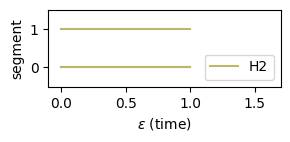

In [17]:
cubical_complex = gudhi.CubicalComplex(vertices = G1.numpy())
cubical_complex.compute_persistence(homology_coeff_field = 2, min_persistence = 0.0)
barc0 = cubical_complex.persistence_intervals_in_dimension(0)[0:-1,]
barc1 = cubical_complex.persistence_intervals_in_dimension(1)
barc2 = cubical_complex.persistence_intervals_in_dimension(2)
barc3 = cubical_complex.persistence_intervals_in_dimension(3)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((3, 1))

ax.set_xlim(-0.1, 1.7)
ax.set_ylim(-0.5, 1.5)

plot_barcodes([barc0, barc1, barc2, barc3])

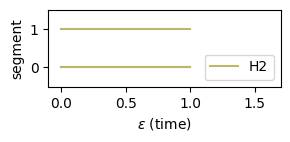

In [18]:
cubical_complex = gudhi.CubicalComplex(vertices = G2.numpy())
cubical_complex.compute_persistence(homology_coeff_field = 2, min_persistence = 0.0)
barc0 = cubical_complex.persistence_intervals_in_dimension(0)[0:-1,]
barc1 = cubical_complex.persistence_intervals_in_dimension(1)
barc2 = cubical_complex.persistence_intervals_in_dimension(2)
barc3 = cubical_complex.persistence_intervals_in_dimension(3)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((3, 1))

ax.set_xlim(-0.1, 1.7)
ax.set_ylim(-0.5, 1.5)

plot_barcodes([barc0, barc1, barc2, barc3])

The two segmentations are indistinguishable with persistence barcodes.

Compute F-Cross-Barcodes

In [19]:
sfd = SFDLossGudhi(dims = [0, 1, 2, 3])

In [20]:
sfd(G1, G2)
pers0 = sfd.cubical_complex.persistence_intervals_in_dimension(0)[0:-1,]
pers1 = sfd.cubical_complex.persistence_intervals_in_dimension(1)
pers2 = sfd.cubical_complex.persistence_intervals_in_dimension(2)
pers3 = sfd.cubical_complex.persistence_intervals_in_dimension(3)

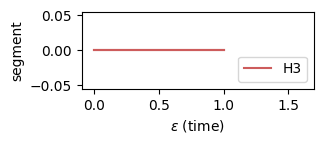

In [21]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((3, 1))

ax.set_xlim(-0.1, 1.7)

plot_barcodes(np.array([pers0, pers1, pers2, pers3], dtype = object))

In [22]:
sfd(G2, G1)
pers0 = sfd.cubical_complex.persistence_intervals_in_dimension(0)[0:-1,]
pers1 = sfd.cubical_complex.persistence_intervals_in_dimension(1)
pers2 = sfd.cubical_complex.persistence_intervals_in_dimension(2)
pers3 = sfd.cubical_complex.persistence_intervals_in_dimension(3)

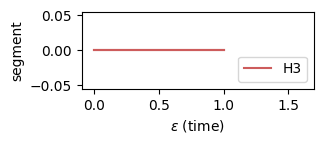

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((3, 1))

ax.set_xlim(-0.1, 1.7)

plot_barcodes(np.array([pers0, pers1, pers2, pers3], dtype = object))

F-Cross-Barcode reveal distinguishing features.

Visualize features

In [24]:
G_marker = torch.zeros((G1.shape[0], G1.shape[1], G1.shape[2]))

In [25]:
sfd = SFDLossGudhi(dims = [0, 1, 2, 3])

In [26]:
sfd(G1, G2)
features = []
for dim in range(4):
    feat_dim = add_markers(G_marker, dim=dim)
    if feat_dim is not None:
        features.extend(feat_dim)

dim 3 65959 60019 (1, 26, 4, 11) (1, 26, 4, 10)


In [27]:
features

[[[26, 4, 11], [26, 4, 10]]]

In [28]:
sfd(G2, G1)
features_inv = []
for dim in range(4):
    feat_dim = add_markers(G_marker, dim=dim)
    if feat_dim is not None:
        features_inv.extend(feat_dim)

dim 3 19069 13129 (1, 11, 9, 3) (1, 11, 9, 2)


In [29]:
features_inv

[[[11, 9, 3], [11, 9, 2]]]

In [30]:
visualize(o_l_aligned, features)

In [31]:
visualize(o_p_aligned, features_inv)